# Code (GA algorithm)

In [123]:
""" 
Module to calculate the fitness of the current generation
"""
from typing import List, Tuple
from numpy import ndarray
import numpy as np
from statsmodels.regression.linear_model import RegressionModel
import statsmodels.api as sm

class _CalculateFit:
    
    def __init__(self):
        pass
    
    def calc_fit_sort_population(self, 
        current_population: ndarray
    ) -> Tuple[ndarray, ndarray]:
        """
        Calculated fitness of organisms and sorts population based on fitness score (AIC). From low AIC (best) to high.
        
        Inputs: Current population
        Outputs: Sorted population, sorted fitness scores
        """
        
        fitness_scores: ndarray = self.calculate_fit_of_population(current_population)
        return self.sort_population(current_population, fitness_scores)
    
    def sort_population(self, 
        current_population: ndarray, fitness_scores
        )-> Tuple[ndarray, ndarray]:
        """
        Sorts population based on fitness score (AIC). From low AIC (best) to high.
        
        Inputs: Current population, Fitness scores per organism
        Outputs: Sorted population, sorted fitness scores
        """
        
        sort_index = np.argsort(fitness_scores)
        
        return current_population[sort_index], fitness_scores[sort_index]
    
    
    def calculate_fit_of_population(self, 
        current_population: ndarray
        ) -> ndarray:
        """
        Calculates fitness of all organism in generation.
        
        Inputs: Current population
        Outputs: Fitness score per organism
        """
        fitness_scores = []
        for organism in current_population:
            X_trimmed = self.select_features(organism)
            fitness_scores.append(self.calculate_fit_per_organism(X_trimmed))
        return np.array(fitness_scores)
            
    def calculate_fit_per_organism(self, X_trimmed: ndarray) -> float:
        """
        Calculates fitness of one organism based on trimmed data according to its allels.
        
        Inputs: Trimmed data
        Outputs: Fitness score of organism
        """
        X_trimmed_w_intercept = sm.add_constant(X_trimmed)
        mod = self.mod(self.y, X_trimmed_w_intercept)

        # Check if the model is an instance of RegressionModel
        if not isinstance(mod, RegressionModel):
            raise TypeError(f"The model must be an instance of a statsmodels linear regression model. Instead it is {type(mod)}")
        
        #print(mod.fit().params)

        aic = mod.fit().aic
        return aic
        
    def select_features(self, organism: ndarray) -> ndarray:
        """
        Drops non-relevant features from data based on allels of an organism.
        
        Inputs: Single organism - Size: (1 x C (number of predictors))
        Outputs: Data to be used for fitness calculation of this organism
        """
      
        X_trimmed = self.X.drop(columns=self.X.columns[organism == 0], axis=1)
        #X_trimmed = self.X[:, organism != 0]

        return X_trimmed

In [124]:
""" 
Module to perform crossover (genetic operator) to the current generation
"""
import numpy as np
from numpy import ndarray

class _CrossOver:
    
    def __init__(self):
        pass
    
    def split_and_glue_population(self, current_population: ndarray) -> ndarray:
        """
        Performs split-and-glue crossover to current population (assuming 1&2 is paired, 3&4, etc.)
       
        Inputs: Current population
        Outputs: Population of children (pairwise cross-over)
        """
        count = 0
        new_population = np.zeros(current_population.shape).astype(int)
        for pair in np.arange(int(current_population.shape[0]/2)):
            new_population[count], new_population[count+1] = self.split_and_glue(current_population[count], current_population[count+1])
            count += 2
        return new_population

    
    def split_and_glue(self, parent1, parent2):
        """
        Crossover two parents to create two children. 
        The method used here is a simple split and glue approach. 
        The split position is randomly created.
        
        Inputs: Two parent organisms
        Outputs: Two child organisms (crossed-over)
        """
        cut_idx = np.random.randint(0, len(parent1))
        child1 = np.concatenate((parent1[0:cut_idx], parent2[cut_idx:]))
        child2 = np.concatenate((parent2[0:cut_idx], parent1[cut_idx:]))
        return child1, child2
    
    
    def random_allel_selection_population(self, current_population: ndarray) -> ndarray:
        """
        Performs random allel selection crossover to current population (assuming 1&2 is paired, 3&4, etc.)
       
        Inputs: Current population
        Outputs: Population of children (pairwise cross-over)
        """
        count = 0
        new_population = np.zeros(current_population.shape)
        for pair in np.arange(int(current_population.shape[0]/2)):
            new_population[count], new_population[count+1] = self.random_allel_selection(current_population[count], current_population[count+1])
            count += 2
        return new_population
    
    def random_allel_selection(self, parent1, parent2):
        """
        Crossover two parents to create two children. 
        The method randomly selects an allel from one of the parents per loci.
        
        Inputs: Two parent organisms
        Outputs: Two child organisms (crossed-over)
        """
        rng = np.random.default_rng()
        
        allel_selector = rng.binomial(1, 0.5, size = parent1.shape[0])
        allel_selector_reversed = 1-allel_selector
        
        child1 = allel_selector*parent1 + allel_selector_reversed*parent2
        child2 = allel_selector*parent2 + allel_selector_reversed*parent1
        return child1, child2

In [125]:
""" 
Mutation module with genetic operator "mutation"
"""

import numpy as np
from numpy import ndarray
class _Mutation:
    
    def __init__(self):
        pass

    def random_mutate(self, current_population: ndarray) -> ndarray:
    
        """
        Randomly switches genes (bit switch) in generation with probability mutate_prob

        Inputs: Generation of organisms - Size: (pop_size x C (number of predictors))
        Outputs: Generation of mutated organisms of same size
        
        """

        # initialize random generator
        rng = np.random.default_rng()
        
        population_new = current_population.copy()
        mutation_locations = rng.binomial(1, self.mutate_prob, size=current_population.shape)
        mask = mutation_locations == 1
        population_new[mask] = 1 - population_new[mask]  # flip bits using the mask
        return population_new


In [126]:
class _ParentSelection:

    def __init__():
        pass

    def calculate_phi(self, current_population):
        """
        Calculate selection probability as 2r_i/P(P+1)
        """
        P = self.pop_size    # Best ranked is P, then P-1, P-2,...,1
        rs = np.arange(P, 0, -1)
        phi = 2 * rs/(P*(P+1))

        return phi

    def select_from_fitness_rank(self, current_population):
        """
        Choose parents based on fitness ranks
        """
        selection_prob = self.calculate_phi(current_population)
                
        row_idx = np.arange(len(current_population))
        chosen_rows = np.random.choice(row_idx, size=self.pop_size, p=selection_prob,replace=True)
        chosen_individuals = current_population[chosen_rows]

        return chosen_individuals

In [127]:
import random
from functools import partial
from typing import Callable, List
import statsmodels.api

import numpy as np
from numpy import ndarray

#from .utils import _CalculateFit, _CrossOver, _Mutation, _ParentSelection

class GA (_CalculateFit,
          _ParentSelection,
          _CrossOver,
          _Mutation
         ):
    def __init__(
        self, 
        X: ndarray,
        y: ndarray,
        mod: Callable,
        max_iter: int,
        pop_size: int = None,  # type: ignore
        # fitness_func = "AIC",
        starting_population: ndarray = None,  # type: ignore
        mutate_prob: float = 0.01,
        save_sols: bool = False,
        random_seed: int = None,  # type: ignore
        ):
        """
        parameters:
        --------
            X: design matrix (assuming no intercept column)
            y: outcome variable
            mod: regression model (statsmodels)
            max_iter: GA max iteration
            pop_size: GA population size
            starting_population: if set use it as initial GA population
            mutate_prob: GA mutation probability
            save_sols: ... TODO
            random_seed: random seed value

        examples:
        --------
   ...: from GA import *
   ...: import statsmodels.api as sm
   ...: import numpy as np
   ...: 
   ...: spector_data = sm.datasets.spector.load()
   ...: 
   ...: X = spector_data.exog
   ...: y = spector_data.endog
   ...: 
   ...: # Initialize GA class
   ...: ga_1 = GA(X=X, y=y, mod=sm.OLS, max_iter=10, random_seed=1)
   ...: 
   ...: # Run GA under default operators
   ...: final_pop, fit = ga_1.select()
   ...: print(final_pop, fit)

   ...: # Specify own operator, population size, and mutation probability
   ...: operator = [GA.random_mutate, GA.random_mutate, GA.split_and_glue_population]
   ...: ga_2 = GA(X=X, y=y, mod=sm.OLS, max_iter=10, pop_size = 4, mutate_prob=0.01, random_seed=12) TODO
   ...: final_pop, fit = ga_2.select(operator)
   ...: print(final_pop, fit)   
        """
        self.random_seed: int = random_seed
        if random_seed:
            np.random.seed(self.random_seed)
            random.seed(self.random_seed)

        self.C: int = X.shape[1]    # this is ASSUMING NO intercept column

        if pop_size is None:
            self.pop_size: int = int(1.5 * self.C)    # C < P < 2C
        else:
            self.pop_size: int = pop_size

        self.X: ndarray = X
        self.y: ndarray = y
        self.mod: Callable = mod
        self.max_iter: int = max_iter
        self.mutate_prob: float = mutate_prob
        # self.fitness_func = fitness_func
        self.starting_population: ndarray = starting_population
        self.current_population = None

        if save_sols == True:
            self.solutions_matrix = np.zeros((self.max_iter, self.C))    # Pre-specify matrix for storing solutions
        else:
            pass

    def initialize_pop(self):
        """
        Creates the starting population
        returns:
            starting_population: ndarray (random bool matrix used to sample self.X)
        """
        if not isinstance(self.starting_population, ndarray):    # Specify a starting pop
            if self.pop_size % 2 == 1:    # If pop_size is odd
                self.pop_size = self.pop_size + 1    # Only allow even number for population size
                print(f"Original pop_size is odd - new pop_size: {self.pop_size}")
            
            cols = self.C
            self.starting_population = np.random.choice([0, 1], size=(self.pop_size, cols))    # Complete random generation
            
        else:
            pass
            
        self.starting_population = self.replace_zero_chromosome(self.starting_population)    # Replace chromosome of all zeros
        
        return self.starting_population

    def select(self, operator_list: List[Callable] = None):
        """
        Runs variable selection based on a user-defined genetic operator sequence: operator_list            
        """
        """Set random seed"""
        random.seed(self.random_seed)

        # set default mutation methods
        # assigns user specified operator_list if its not None
        operator_list = operator_list or [
            self.split_and_glue_population,
            self.random_mutate,
            ]       
        #for i, f in enumerate(operator_list):
        #    if f.__name__ == "random_mutate":
        #        operator_list[i] = partial(f, mutate_prob=self.mutate_prob)
        print(f"Using genetic operators: {operator_list}.")

        """Prepare GA"""
        starting_pop = self.initialize_pop()
        current_pop = starting_pop.copy()

        for i in range(self.max_iter):
            """Calculates fitness and pairs parents"""
            # chrom_ranked: ordered bool matrix(current_pop) from the fittest to unfittest
            chrom_ranked, fitness_val = self.calc_fit_sort_population(current_pop)
            parents = self.select_from_fitness_rank(chrom_ranked)
            current_pop = parents    # update current_pop's chromosome
            print(f"[iteration {i+1}] score: {fitness_val[0]:3.4f} | {chrom_ranked[0]}")

            # Runs genetic operator sequence
            for method in operator_list:
                new_population = method(current_pop)
                current_pop = new_population
            
            # Check if any chromosome of zeros and replace the row
            current_pop = self.replace_zero_chromosome(current_pop)    
        
        final_pop = current_pop.copy()
        self.final_pop_sorted, self.final_fitness_val = self.calc_fit_sort_population(final_pop)
        
        return (self.final_pop_sorted[0], self.final_fitness_val[0])
    
    def replace_zero_chromosome(self, population):
        """
        Finds if any chromosome is all zeros, and replaces the zero rows with random 0,1s
        """
        while np.any((population == 0).all(axis=1)):
            # Find the indices of rows with all zeros
            zero_rows_indices = np.where((population == 0).all(axis=1))[0]

            # Replace each zero row with a randomly generated 0,1 row
            for row_index in zero_rows_indices:
                population[row_index] = np.random.randint(0, 2, self.C)
        
        return population
            



In [138]:
import pandas as pd 
import statsmodels.api as sm

data = pd.read_csv("./assets/baseball.dat", delimiter = ' ')

X = data.drop("salary", axis = 1)
y = data["salary"]

In [129]:
GA1 = GA(pop_size=26, X=X, y=y, mod=sm.OLS, max_iter=100)

In [130]:
GA1.select()

Using genetic operators: [<bound method _CrossOver.split_and_glue_population of <__main__.GA object at 0x7f782574a380>>, <bound method _Mutation.random_mutate of <__main__.GA object at 0x7f782574a380>>].
[iteration 1] score: 5391.0676 | [0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0]
[iteration 2] score: 5388.1033 | [0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0]
[iteration 3] score: 5388.1033 | [0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0]
[iteration 4] score: 5382.2537 | [0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0]
[iteration 5] score: 5380.9254 | [0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0]
[iteration 6] score: 5378.8729 | [0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0]
[iteration 7] score: 5378.1649 | [0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0]
[iteration 8] score: 5377.7796 | [0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1]
[iteration 9] score: 5375.8498 | [0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 

[iteration 91] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 92] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 93] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 94] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 95] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 96] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 97] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 98] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 99] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
[iteration 100] score: 5373.5965 | [0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0]


(array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0]),
 5373.596497254596)

# Example 1: Baseball data

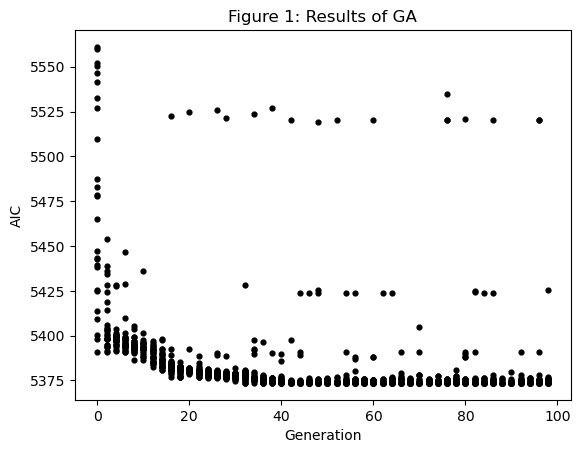

In [131]:
import matplotlib.pyplot as plt

starting_pop = GA1.initialize_pop()
current_pop = starting_pop.copy()
operator_list = [GA1.split_and_glue_population, GA1.random_mutate]

for i in range(GA1.max_iter):
    # Calculates fitness and pairs parents
    chrom_ranked, fitness_val = GA1.calc_fit_sort_population(current_pop)
    parents = GA1.select_from_fitness_rank(chrom_ranked)
    current_pop = parents
    if i%2 == 0:
        plt.scatter([i]*len(fitness_val), fitness_val, color = "black", s=12)

    # Runs genetic operator sequence
    for method in operator_list:
        new_population = method(current_pop)
        current_pop = new_population
    # Check if any chromosome of zeros and replace the row
    current_pop = GA1.replace_zero_chromosome(current_pop)    

plt.ylabel("AIC")
plt.xlabel("Generation")
plt.title("Figure 1: Results of GA")
#plt.savefig("GA_results_plot_baseball.png")

final_pop = current_pop.copy()
GA1.final_pop_sorted, GA1.final_fitness_val = GA1.calc_fit_sort_population(final_pop)

fittest_org, fittest_score = (GA1.final_pop_sorted[0], GA1.final_fitness_val[0])

In [132]:
fittest_org, fittest_score

(array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0]),
 5373.596497254596)

# Example 2: Synthetic dataset

In [159]:
n_samples = 100

# Generate independent variables
X2 = np.random.rand(n_samples, 5)  # 5 independent variables

# Define a known relationship
y2 = 3 * X2[:, 0] + 2 * X2[:, 1] + np.random.normal(0, 0.5, n_samples)

# Create a DataFrame
data = pd.DataFrame(X2, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
data['y2'] = y2

X2 = data.drop("y2", axis = 1)
y2 = data["y2"]
sa = GA(X=X2, y=y2, mod=sm.OLS, max_iter=30, mutate_prob=0.01)

In [160]:
sa.select()

Using genetic operators: [<bound method _CrossOver.split_and_glue_population of <__main__.GA object at 0x7f78257eff10>>, <bound method _Mutation.random_mutate of <__main__.GA object at 0x7f78257eff10>>].
Original pop_size is odd - new pop_size: 8
[iteration 1] score: 141.8268 | [1 1 0 0 1]
[iteration 2] score: 141.8268 | [1 1 0 0 1]
[iteration 3] score: 141.8268 | [1 1 0 0 1]
[iteration 4] score: 142.4875 | [1 1 1 0 0]
[iteration 5] score: 142.4875 | [1 1 1 0 0]
[iteration 6] score: 142.4875 | [1 1 1 0 0]
[iteration 7] score: 140.5187 | [1 1 0 0 0]
[iteration 8] score: 140.5187 | [1 1 0 0 0]
[iteration 9] score: 140.5187 | [1 1 0 0 0]
[iteration 10] score: 140.5187 | [1 1 0 0 0]
[iteration 11] score: 140.5187 | [1 1 0 0 0]
[iteration 12] score: 140.5187 | [1 1 0 0 0]
[iteration 13] score: 140.5187 | [1 1 0 0 0]
[iteration 14] score: 140.5187 | [1 1 0 0 0]
[iteration 15] score: 140.5187 | [1 1 0 0 0]
[iteration 16] score: 140.5187 | [1 1 0 0 0]
[iteration 17] score: 140.5187 | [1 1 0 0 

(array([1, 1, 0, 0, 0]), 140.51872246887942)

# Comparison with Lasso

In [134]:
# Fit Lasso

In [139]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = sm.add_constant(X_scaled)

In [140]:
Lasso = sm.OLS(y, X).fit_regularized(method = "elastic_net", alpha = 0.1, L1_wt = 1)
lasso_params= Lasso.params.sort_values()

<BarContainer object of 27 artists>

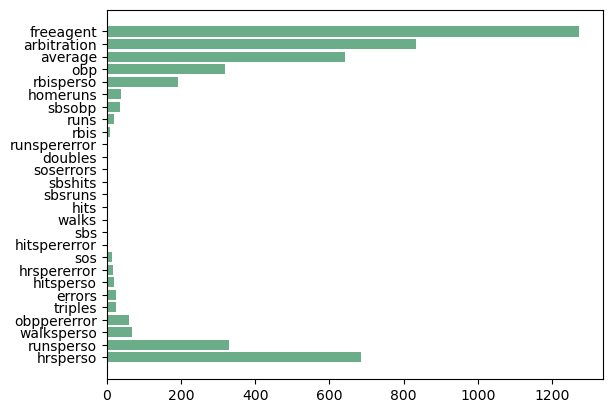

In [141]:
import matplotlib.pyplot as plt
import numpy as np
plt.barh(lasso_params.index, np.abs(lasso_params.values), label = "Lasso", color = "seagreen", align = "center", alpha = 0.7)

In [142]:
# Regression on fittest organism from GA

In [143]:
X_trimmed = X.drop(X.columns[fittest_org == 0], axis=1)

In [144]:
Regression_GA = sm.OLS(y, X_trimmed).fit()
reg_params = pd.Series(index = lasso_params.index).fillna(0)
reg_params[Regression_GA.params.index] = Regression_GA.params.values

/var/folders/9v/21xqllks32b9v9gj8tm8bf4m0000gn/T/ipykernel_48975/2490332900.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  reg_params = pd.Series(index = lasso_params.index).fillna(0)


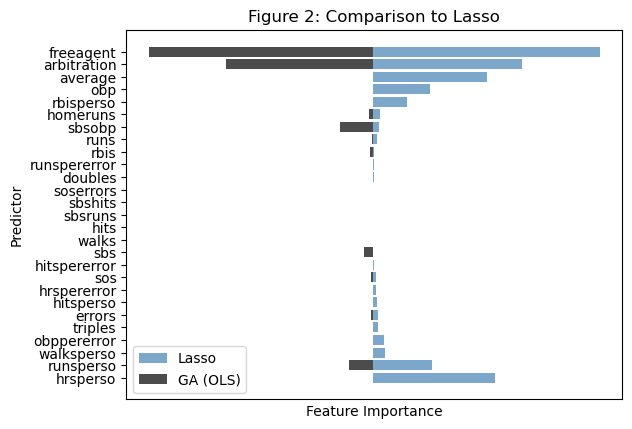

In [145]:
# Plot
plt.barh(lasso_params.index, np.abs(lasso_params.values), label = "Lasso", color = "steelblue", align = "center", alpha = 0.7)
plt.barh(lasso_params.index, -np.abs(reg_params.values), label = "GA (OLS)", color = "black", align = "center", alpha = 0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Predictor")
plt.title("Figure 2: Comparison to Lasso")
plt.legend()
plt.xticks([])
plt.savefig("LASSO_comparison.png")

In [4]:
from GA import *
import statsmodels.api as sm
import numpy as np

spector_data = sm.datasets.spector.load()

X = spector_data.exog
y = spector_data.endog

# Initialize GA class
ga_1 = GA(X=X.values, y=y.values, mod=sm.OLS, max_iter=10, random_seed=1)

# Run GA under default operators
final_pop, fit = ga_1.select()
print(final_pop, fit)


ModuleNotFoundError: No module named 'GA'